In [1]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/BTC-USD.csv')
data = df.filter(['Close'])
df['Date']= pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
dataset = data.values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.45174988],
       [0.44834716],
       [0.44822465]])

In [4]:
train_ratio = 0.8
training_data_len = int(np.round( train_ratio * len(dataset)))
training_data_len

2578

In [5]:
lookback = 60
x_train, y_train = [], []

for i in range(lookback, len(scaled_data)):
    x_train.append(scaled_data[i-lookback:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0076 - val_loss: 0.0039
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.0994e-04 - val_loss: 0.0039
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.0681e-04 - val_loss: 0.0046
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.9327e-04 - val_loss: 0.0019
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5.0675e-04 - val_loss: 0.0011
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2279e-04 - val_loss: 8.4442e-04
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.9662e-04 - val_loss: 0.0031
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8308e-04 - val_loss: 0.0046
Epoch 12/20
80/80 ━━━━━━━━━━━━

In [8]:
test_data = scaled_data[training_data_len - lookback:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(lookback, len(test_data)):
    x_test.append(test_data[i-lookback:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
mae = np.mean(np.abs(predictions - y_test))
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print('RMSE: ', rmse)
print('MAE: ', mae)
print('MAPE: ', mape)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE:  77.5302324143053
MAE:  1044.0657738904308
MAPE:  3.3710911964795893


<ipython-input-10-992653416861>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


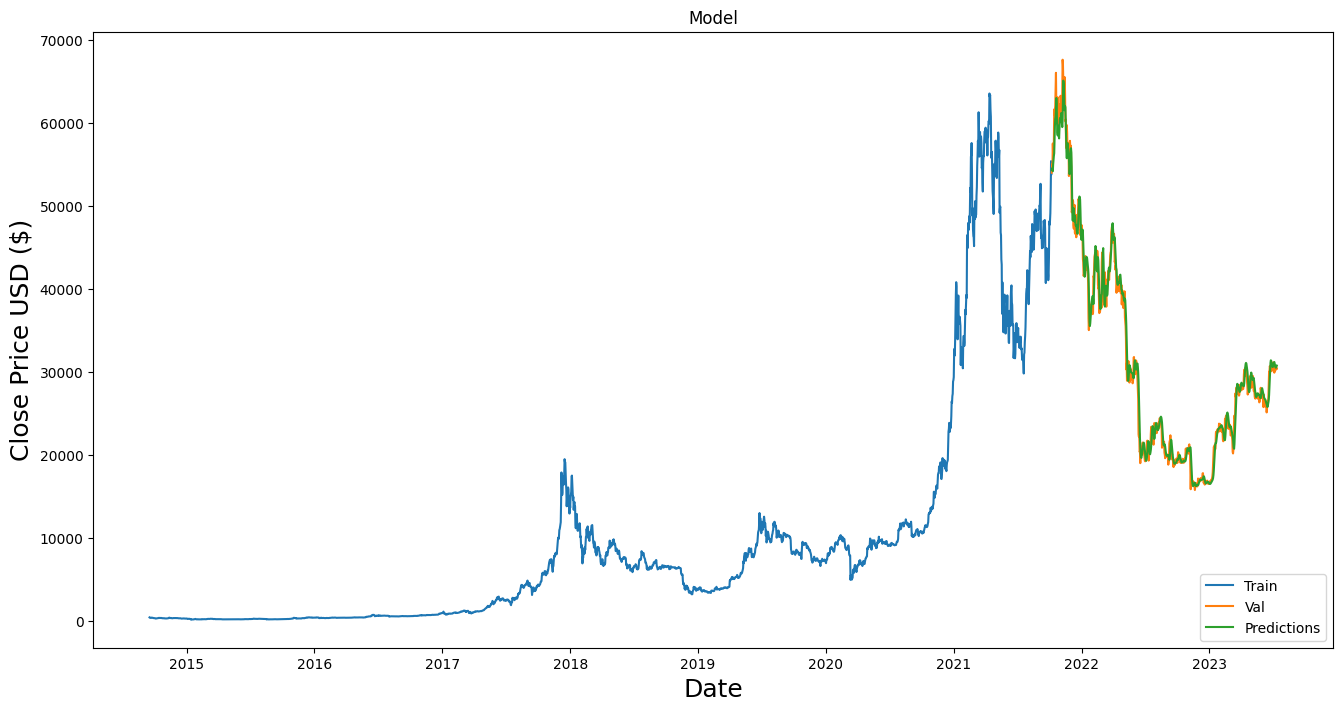

In [10]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train.index, train['Close'])
plt.plot(valid.index, valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()